# APLICAÇÃO DE UMA REDE NEURAL LSTM --> PREDICT: SEM DADOS REAIS PARA COMPARAR, MAS BUSCANDO CONVERGIR COM OS RESULTADOS DOS MODELOS DE CLASSIFICAÇÃO SOBRE OS DADOS DE PREÇO E DADOS FUNDAMENTALISTAS.

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
import pandas_datareader.data as web
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.
/home/jarbasjr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jarbasjr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jarbasjr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jarbasjr/.local/lib/python3.6/site-packages/tensorflo

# Extraindo valores da API Yahoo Finance

Os dados foram extraídos em escala temporal de "semana", no caso 'wk'

Tirando "Date" que era um índice e o colocando como uma coluna normal.

Colocamos Date como a primeira posição entre as colunas.

In [2]:
start = datetime(2000, 3, 1)
end = datetime(2019, 8, 14)
base = web.get_data_yahoo('VALE3.SA', start, end, interval = 'wk')

base["Date"] = base.index
base.reset_index(drop=True, inplace=True)


date = base['Date']
base.drop(labels=['Date'], axis=1,inplace = True)
base.insert(0, 'Date', date)

In [3]:
base

,Date,High,Low,Open,Close,Volume,Adj Close
0,2000-02-28,3.416670,3.290830,3.400000,3.290830,1440000.0,2.187071
1,2000-03-06,3.315000,3.166670,3.290830,3.166670,705600.0,2.104556
2,2000-03-13,3.166670,3.000000,3.166670,3.024170,20688000.0,2.009851
3,2000-03-20,3.208330,2.750000,3.025000,3.208330,5203200.0,2.132242
4,2000-03-27,3.333330,3.125000,3.250000,3.333330,4300800.0,2.215317
...,...,...,...,...,...,...,...
1011,2019-07-15,53.470001,52.230000,52.459999,52.720001,75154900.0,52.720001
1012,2019-07-22,52.660000,50.099998,52.180000,50.230000,72983100.0,50.230000
1013,2019-07-29,50.599998,47.410000,50.299999,47.840000,107425300.0,47.840000
1014,2019-08-05,47.490002,45.450001,46.599998,45.490002,128177000.0,45.490002


In [4]:
base = base.dropna()

In [5]:
base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1015
Data columns (total 7 columns):
Date         1016 non-null datetime64[ns]
High         1016 non-null float64
Low          1016 non-null float64
Open         1016 non-null float64
Close        1016 non-null float64
Volume       1016 non-null float64
Adj Close    1016 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 63.5 KB


In [6]:
base_train = base.iloc[:, 1:7].values

# Normalização

Vamos precisar fazer ruma normalização nesses dados, pos quando se trabalha com esse tipo de rede neural, como existem muitas camadas e principalmente o fato de cada camada apontar pra ela mesma para passar informação ele pode ficar bastante lento se for utilizado os valores reais, então vamos aplicar uma normalização para que consigamos colocar esses valores em uma escala de 0 até 1.

In [7]:
normalizer = MinMaxScaler(feature_range=(0,1))
base_train_normalizer = normalizer.fit_transform(base_train)

## No código, queremos prever o preço da ação baseado nos 90 valores anteriores, então irá começar a partir do valor de indice 90

## Preencher dois vetores, o de previsores e o de preço real

## previsores: a cada iteração retira do "base_treinamento_normaliza" e vai retirando os preços de 90 em 90, por exemplo, primeiro tira os valores de '0 a 119', depois '1 a 120', '2 a 121'e etc... Sempre assim de 120 em 120, colocando cada grupo desses 120 em cada coluna da variavel previsores

## preço_real: a cada iteração coloca um valor a partir do indice 120 de "base_treinamento_normalizada'.

In [8]:
previsores = []
preco_real = []

for i in range(120, 1016):
    previsores.append(base_train_normalizer[i-120:i, 0:6])
    preco_real.append(base_train_normalizer[i, 0])
    
previsores, preco_real = np.array(previsores), np.array(preco_real)

## Na LSTM tem um formato de input shape, configurada na imagem

## 'batch_size': Se referindo a quantidade de registros.

## 'timesteps': Quantos intervalos de tempo, que seriam as colunas, que poderiam ser, por exemplo, t1, t2, t3, cada coluna representa uma unidade do preço da ação no tempo.

## 'input_dim': Temos 6 indicadores, e com base nesses dados dessa coluna no passado quero prever no futuro. Caso queria utilizar mais atributos previsores pode-se aumentar a dimensionalidade no terceiro item.

In [9]:
previsores.shape

(896, 120, 6)

In [10]:
preco_real.shape

(896,)

In [11]:
input_shape = (previsores.shape[1],6)

## Estrutura da Rede Neural

Units equivale a o número de células de memoria, deve ser um número grande pra adicionar mais dimensionalidade e caputar a tendência no decorrer do tempo, se for um valor muito baixo não irá conseguir capturar variação temporal 

Return_sequences = utiliza somente quando terá mais de uma camada LSTM, indica irá passar a informação para as próximas camadas subsequentes abaixo a primeira camada

Com esse tipo de rede neural é interessente adicionar mais camdas para ter bons resultados, nesse caso serão 4.

Aqui pode-se reduzir o número de neuronios/células de memória, em alguns casos pode-se colocar valor mais alto nos primeiro e depois dimuir, fazer testes para verificar resultados.

Retira o 'return_sequences', só colocar quando tem mais camadas subsequentes No caso, após, é somente a camada de saída.

Camada de saída, como é apenas a coluna 'close' que estamos predizendo, somente uma unit. Função linear já que é um caso de regressão.

In [12]:
regressor = Sequential()

regressor.add(LSTM(units = 100, return_sequences = True, input_shape = input_shape))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

regressor.add(Dense(units = 1, activation = 'linear'))

RMSprop é um otimizador para RNN.

"mean_squared_error" calculo de erro mais eficiente de calculo do erro.

"mean_absolute_error" como ele faz absoluto fica mais facil entender os resultados.

In [13]:
regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error',
                         metrics = ['mean_absolute_error'])

# Procesos de treinamento - Interessante rodar PELO MENOS umas 100 epócas se não ele tende a não se adaptar aos dados.

In [14]:
%%time
regressor.fit(previsores, preco_real, epochs =100, batch_size = 32 )

W1116 04:59:45.700766 140441958512448 deprecation_wrapper.py:119] From /home/jarbasjr/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/100
896/896 [==============================] - 29s 32ms/step - loss: 0.0368 - mean_absolute_error: 0.1325
Epoch 2/100
896/896 [==============================] - 27s 30ms/step - loss: 0.0171 - mean_absolute_error: 0.0970
Epoch 3/100
896/896 [==============================] - 24s 27ms/step - loss: 0.0144 - mean_absolute_error: 0.0912
Epoch 4/100
896/896 [==============================] - 26s 30ms/step - loss: 0.0133 - mean_absolute_error: 0.0865
Epoch 5/100
896/896 [==============================] - 23s 26ms/step - loss: 0.0115 - mean_absolute_error: 0.0773
Epoch 6/100
896/896 [==============================] - 27s 31ms/step - loss: 0.0126 - mean_absolute_error: 0.0822
Epoch 7/100
896/896 [==============================] - 29s 32ms/step - loss: 0.0098 - mean_absolute_error: 0.0719
Epoch 8/100
896/896 [==============================] - 30s 33ms/step - loss: 0.0095 - mean_absolute_error: 0.0703
Epoch 9/100
896/896 [==============================] - 29s 33ms/step - loss: 0.0093 - me

# PROCESSO DE TESTE

Tendo como métrica, antes de plotar o gráfico que irá predizer para o futuro.

In [15]:
start = datetime(2000, 3, 1)
end = datetime(2019, 8, 14)
base_complete = web.get_data_yahoo('VALE3.SA', start, end, interval = 'wk')

base_complete["Date"] = base_complete.index
base_complete.reset_index(drop=True, inplace=True)


date = base_complete['Date']
base_complete.drop(labels=['Date'], axis=1,inplace = True)
base_complete.insert(0, 'Date', date)
base_complete = base_complete.dropna()

base_complete = base_complete.iloc[:, 1:7]
base_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1015
Data columns (total 6 columns):
High         1016 non-null float64
Low          1016 non-null float64
Open         1016 non-null float64
Close        1016 non-null float64
Volume       1016 non-null float64
Adj Close    1016 non-null float64
dtypes: float64(6)
memory usage: 55.6 KB


Aqui é o momento onde definimos de qual índice será feito a janela deslizante.

Vamos observar.

Temos a base completa, com o base de dados de treinamento concateanda a base de testes. Assim o nosso índice de de interesse será o resultante da base complea menos a base de teste - menos o tamanho da nossa janela deslizante.

Assim teremos o momento exato que a LSTM deverá atuar para predizer a primeira amostra da base de teste, eassim completar os 120 previsores da base de dados de teste.

E ainda colocando os dados na mesma escala. Aqui não chamamos o método '.fit_transform', pq ele vai normalizar as entradas de acordo com o que ja foi normalizado lá na 'base_train_normalizer'.

In [16]:
entradas = base_complete[len(base_complete) - 52 - 120:].values
entradas = normalizer.transform(entradas)
entradas.shape

(172, 6)

Na variavel 'entradas' pegamos 172 valores, e no 'for' a cada iteração pega um range de 120 valores e coloca em cada coluna primeiro de '0 á 119', '1 á 120' e assim por diante. Até valores de '2 á 121'.

Pegando 52 ranges de 120 valores há 52 linhas de 120 valores de ações, onde cada valor é o 'close' de um dia em sequência.

In [17]:
X_test = []

for i in range(120,172):
    X_test.append(entradas[i-120:i, 0:6])
    

X_test = np.array(X_test)

In [18]:
X_test.shape

(52, 120, 6)

In [19]:
previsoes = regressor.predict(X_test)

In [20]:
previsoes.shape

(52, 1)

Aqui, devemos normalizar a base de treinamento correspondente a variavel que estamos predizendo, no caso a coluna "close". 

In [21]:
normalizer_previsao = MinMaxScaler(feature_range=(0,1)) 
normalizer_previsao.fit_transform(base_complete.iloc[:,3:4].values)

array([[0.00386095],
       [0.00206325],
       [0.        ],
       ...,
       [0.64888575],
       [0.61486026],
       [0.59169392]])

'Desnormalizando' para visualizar os resultados das previsoes dos preços efetivamente, e compara-los com valores reais.

In [22]:
previsoes = normalizer_previsao.inverse_transform(previsoes)

# Gráfico da Predição

Indica que a ação não subiria 10% no próximo 1 ano, ou 52 semanas que é a escala temporal usada.

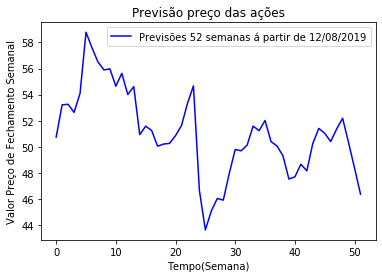

In [23]:
plt.plot(previsoes, color = 'blue', label = 'Previsões 52 semanas á partir de 12/08/2019')
plt.title('Previsão preço das ações')
plt.xlabel('Tempo(Semana)')
plt.ylabel('Valor Preço de Fechamento Semanal')
plt.legend()
plt.show()